# Exploratory Data Analysis on Enron Email

# Objectives 
1. Extract text corpus from enron email
2. Explore data structure and perform some cleaning if needed
3. Form hypothesis, frame questions on possible project direction

## 1. Data Extraction

In [ ]:
import tarfile
import os

archive_path = '..\data\enron_mail_20150507.tar.gz'
destination_path = '..\data\extracted_data'


# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Open the tar.gz file and extract all its contents
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall(path=destination_path)

print(f"All files from '{archive_path}' extracted to '{destination_path}'")



All files from '..\data\enron_mail_20150507.tar.gz' extracted to '4_enron_mail_nlp\data\extracted_data'


### 1a. Loading Data

  1. Read individual email files from each mail box
  2. Put into a dataframe, dedup and tag mailbox source 

### Function for parsing email

In [ ]:
import pandas as pd
import email
from email import policy
import os
import glob
import io
import chardet

# Function to parse a single email file and extract relevant data
def parse_email_file(file_path):
    """
    Parses an email file and returns a dictionary with extracted information.
    """

    sub_mailbox = file_path.split(os.sep)[5]
    if os.path.isfile(file_path)==False:
        sub_mailbox2 = file_path.split(os.sep)[6:]
    else:
        sub_mailbox2 = ''


    try:
        # Detect the file's encoding first
        with open(file_path, 'rb') as raw_file:
            raw_data = raw_file.read()
            detected_encoding = chardet.detect(raw_data)['encoding']


        with open(file_path, 'r', encoding=detected_encoding, errors='replace') as email_file:
            content = email_file.read()#email.message_from_file(email_file, policy=policy.default)
            content = io.StringIO(content)
            msg = email.message_from_file(content, policy=policy.default)
            
            message_id = msg['Message-ID']
            date = msg['Date']
            subject = msg['Subject']
            to_addr = msg['To']
            from_addr = msg['From']
            person_box = msg['X-Origin']
            
            # Handle both plain text and multipart emails for the body
            if msg.is_multipart():
                body = ""
                for part in msg.walk():
                    if part.get_content_type() == "text/plain":
                        body = part.get_payload(decode=True).decode(errors='ignore')
                        break
            else:
                body = msg.get_payload(decode=True).decode(errors='ignore')
            
            email_body = body.strip()

            return {
                'subject': subject,
                'date': date,
                'date_short': date[:17],
                'message_id': message_id,
                'from_addr': from_addr,
                'to_addr': to_addr,
                'person_box': person_box,
                'sub_mailbox': sub_mailbox,
                'sub_mailbox2': "\\".join(sub_mailbox2),
                'email_body': email_body
            }
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None



### Function for recursively reading files from mail directory 

In [ ]:
import os


def read_files_recursively(root_dir,all_email_data):
    """
    Recursively reads all files within a given directory and its subdirectories.

    Args:
        root_dir (str): The path to the starting directory.
    """

    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # dirpath is the current directory being traversed
        # dirnames is a list of subdirectories in dirpath
        # filenames is a list of files in dirpath

        # print(f"Processing directory: {dirpath}")
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            try:
                
                if os.path.isfile(file_path):
                    email_data = parse_email_file(file_path)
                if email_data:
                    all_email_data.append(email_data)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return all_email_data



### Crawl all directories and sub-directories and save to a dataframe

In [7]:
# Example usage:
# Replace 'your_directory_path' with the actual path you want to traverse
all_email_data=[]

# Feed all mail data
read_files_recursively('..\data\extracted_data\maildir',all_email_data )


df_all = pd.DataFrame(all_email_data)

# Print the resulting DataFrame
df_all['date_short']  = pd.to_datetime(df_all['date_short'])
df_all.head(5)

Error processing file ..\data\extracted_data\maildir\kitchen-l\sent_items\24: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\esvl\87: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_eol\82: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_eol\83: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_restart\3: 'ValueTerminal' object does not support item assignment


subject  \
0  December 14, 2000 - Bear Stearns' predictions ...   
1                       Bloomberg Power Lines Report   
2        Consolidated positions: Issues & To Do list   
3        Consolidated positions: Issues & To Do list   
4                                                      

                              date date_short  \
0  Wed, 13 Dec 2000 18:41:00 -0800 2000-12-13   
1  Wed, 13 Dec 2000 08:35:00 -0800 2000-12-13   
2  Mon, 09 Oct 2000 07:16:00 -0700 2000-10-09   
3  Mon, 09 Oct 2000 07:00:00 -0700 2000-10-09   
4  Thu, 05 Oct 2000 06:26:00 -0700 2000-10-05   

                                      message_id  \
0  <29790972.1075855665306.JavaMail.evans@thyme>   
1  <21975671.1075855665520.JavaMail.evans@thyme>   
2   <7452188.1075855667684.JavaMail.evans@thyme>   
3  <23790115.1075855667708.JavaMail.evans@thyme>   
4   <5860470.1075855667730.JavaMail.evans@thyme>   

                                 from_addr person_box    sub_mailbox  \
0  1.11913372.-2@multexinvestornetwork.com    Allen-P  all_documents   
1              messenger@ecm.bloomberg.com    Allen-P  all_documents   
2                  phillip.allen@enron.com    Allen-P  all_documents   
3                  phillip.allen@enron.com    Allen-P  all_documents   
4                  phillip.allen@enron.com    Allen-P  all_documents   

  sub_mailbox2                                         email_body  
0               In today's Daily Update you'll find free repor...  
1               Here is today's copy of Bloomberg Power Lines....  
2               ---------------------- Forwarded by Phillip K ...  
3               ---------------------- Forwarded by Phillip K ...  
4               Dave, \n\n Here are the names of the west desk...

### Checks and Finalizing UNCLEANED DATASET

In [8]:
# df_deleted = df_deleted.drop_duplicates(subset=['message_id'], keep='first')
df_all['date_short']  = pd.to_datetime(df_all['date_short'])
df_all = df_all.drop(columns=['date'])
df_all.describe(include='all')

subject                     date_short  \
count   517396                         517396   
unique  159287                            NaN   
top                                       NaN   
freq     19187                            NaN   
mean       NaN  2001-02-18 23:33:46.452465920   
min        NaN            1979-12-31 00:00:00   
25%        NaN            2000-10-13 00:00:00   
50%        NaN            2001-03-05 00:00:00   
75%        NaN            2001-08-14 00:00:00   
max        NaN            2044-01-04 00:00:00   

                                           message_id           from_addr  \
count                                          517396              517396   
unique                                         517396               20326   
top     <29790972.1075855665306.JavaMail.evans@thyme>  kay.mann@enron.com   
freq                                                1               16735   
mean                                              NaN                 NaN   
min                                               NaN                 NaN   
25%                                               NaN                 NaN   
50%                                               NaN                 NaN   
75%                                               NaN                 NaN   
max                                               NaN                 NaN   

        person_box    sub_mailbox sub_mailbox2  \
count       517367         517396       517396   
unique         259           1427            1   
top     Kaminski-V  all_documents                
freq         26995         128103       517396   
mean           NaN            NaN          NaN   
min            NaN            NaN          NaN   
25%            NaN            NaN          NaN   
50%            NaN            NaN          NaN   
75%            NaN            NaN          NaN   
max            NaN            NaN          NaN   

                                               email_body  
count                                              517396  
unique                                             247871  
top     As you know, Enron Net Works (ENW) and Enron G...  
freq                                                  112  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [9]:
df_deleted = df_all[df_all['sub_mailbox']=='deleted_items']
df_deleted = df_deleted.drop_duplicates(subset=['message_id'], keep='first')
df_deleted.describe(include='all')

subject                     date_short  \
count    51356                          51356   
unique   27386                            NaN   
top        RE:                            NaN   
freq      1914                            NaN   
mean       NaN  2001-11-14 01:05:19.931458816   
min        NaN            1986-04-26 00:00:00   
25%        NaN            2001-10-19 00:00:00   
50%        NaN            2001-11-19 00:00:00   
75%        NaN            2002-01-11 00:00:00   
max        NaN            2024-05-26 00:00:00   

                                           message_id             from_addr  \
count                                           51356                 51356   
unique                                          51356                  8961   
top     <21543395.1075855374340.JavaMail.evans@thyme>  no.address@enron.com   
freq                                                1                  2588   
mean                                              NaN                   NaN   
min                                               NaN                   NaN   
25%                                               NaN                   NaN   
50%                                               NaN                   NaN   
75%                                               NaN                   NaN   
max                                               NaN                   NaN   

       person_box    sub_mailbox sub_mailbox2  \
count       51352          51356        51356   
unique        203              1            1   
top     Shapiro-R  deleted_items                
freq         1488          51356        51356   
mean          NaN            NaN          NaN   
min           NaN            NaN          NaN   
25%           NaN            NaN          NaN   
50%           NaN            NaN          NaN   
75%           NaN            NaN          NaN   
max           NaN            NaN          NaN   

                                               email_body  
count                                               51356  
unique                                              41194  
top     Enron in Action can be accessed through the ne...  
freq                                                   82  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [10]:
df_rest = df_all[df_all['sub_mailbox']!='deleted_items']
df_rest = df_rest.drop_duplicates(subset=['message_id'], keep='first')
df_rest.describe(include='all')

subject                     date_short  \
count   466040                         466040   
unique  141377                            NaN   
top                                       NaN   
freq     17915                            NaN   
mean       NaN  2001-01-20 10:36:37.943523840   
min        NaN            1979-12-31 00:00:00   
25%        NaN            2000-09-26 00:00:00   
50%        NaN            2001-02-01 00:00:00   
75%        NaN            2001-05-29 00:00:00   
max        NaN            2044-01-04 00:00:00   

                                           message_id           from_addr  \
count                                          466040              466040   
unique                                         466040               15591   
top     <29790972.1075855665306.JavaMail.evans@thyme>  kay.mann@enron.com   
freq                                                1               16645   
mean                                              NaN                 NaN   
min                                               NaN                 NaN   
25%                                               NaN                 NaN   
50%                                               NaN                 NaN   
75%                                               NaN                 NaN   
max                                               NaN                 NaN   

        person_box    sub_mailbox sub_mailbox2  \
count       466015         466040       466040   
unique         259           1426            1   
top     Kaminski-V  all_documents                
freq         25894         128103       466040   
mean           NaN            NaN          NaN   
min            NaN            NaN          NaN   
25%            NaN            NaN          NaN   
50%            NaN            NaN          NaN   
75%            NaN            NaN          NaN   
max            NaN            NaN          NaN   

                                               email_body  
count                                              466040  
unique                                             214204  
top     Ken Lay and Jeff Skilling were interviewed on ...  
freq                                                  107  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [11]:
common_df = pd.merge(df_rest, df_deleted, how='inner', on='message_id')
len(common_df)

0

In [ ]:
merged_df = pd.concat([df_rest, df_deleted], ignore_index=True, sort=False)
groupd = merged_df.groupby(['sub_mailbox']).size()
print(groupd.sort_values(ascending=False)[0:11])
# print(groupd)

sub_mailbox
all_documents         128103
discussion_threads     58609
sent                   57653
deleted_items          51356
inbox                  44859
sent_items             37920
notes_inbox            36665
_sent_mail             30109
calendar                6133
archiving               4477
_americas               4017
dtype: int64


In [13]:
merged_df.describe(include='all')

subject                     date_short  \
count   517396                         517396   
unique  159287                            NaN   
top                                       NaN   
freq     19187                            NaN   
mean       NaN  2001-02-18 23:33:46.452465408   
min        NaN            1979-12-31 00:00:00   
25%        NaN            2000-10-13 00:00:00   
50%        NaN            2001-03-05 00:00:00   
75%        NaN            2001-08-14 00:00:00   
max        NaN            2044-01-04 00:00:00   

                                           message_id           from_addr  \
count                                          517396              517396   
unique                                         517396               20326   
top     <29790972.1075855665306.JavaMail.evans@thyme>  kay.mann@enron.com   
freq                                                1               16735   
mean                                              NaN                 NaN   
min                                               NaN                 NaN   
25%                                               NaN                 NaN   
50%                                               NaN                 NaN   
75%                                               NaN                 NaN   
max                                               NaN                 NaN   

        person_box    sub_mailbox sub_mailbox2  \
count       517367         517396       517396   
unique         259           1427            1   
top     Kaminski-V  all_documents                
freq         26995         128103       517396   
mean           NaN            NaN          NaN   
min            NaN            NaN          NaN   
25%            NaN            NaN          NaN   
50%            NaN            NaN          NaN   
75%            NaN            NaN          NaN   
max            NaN            NaN          NaN   

                                               email_body  
count                                              517396  
unique                                             247871  
top     As you know, Enron Net Works (ENW) and Enron G...  
freq                                                  112  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

### 1b. EDA - Inspecting mailbox count

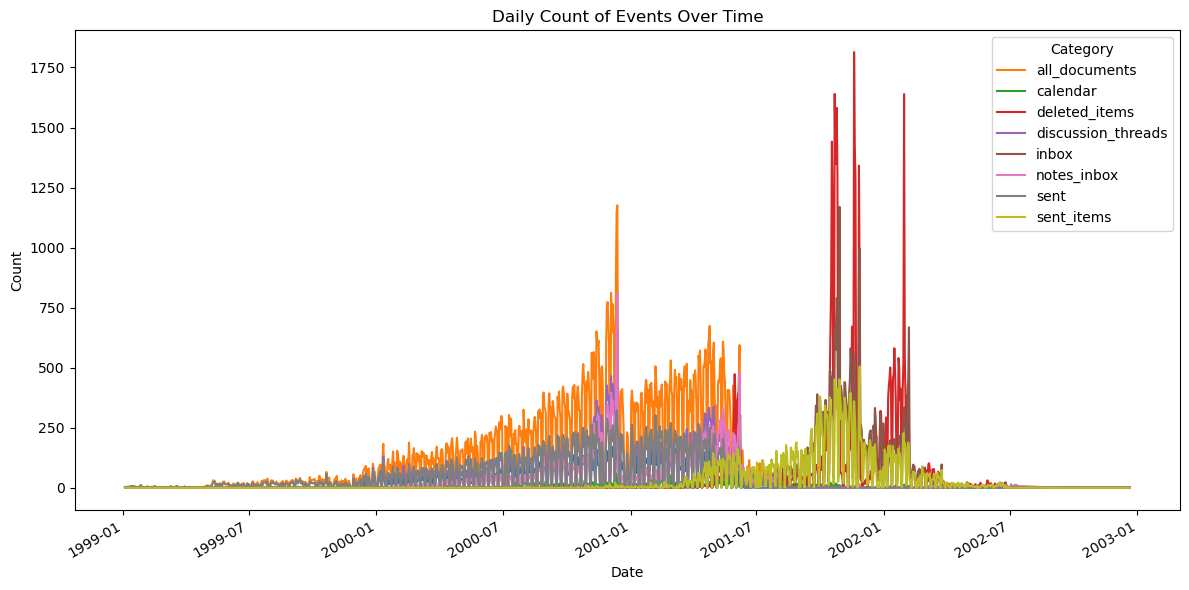

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter top mailbox
mailboxes=['inbox', 'deleted_items', 'sent','sent_items', 'all_documents', 'calendar', '_sent_mail', 'notes_inbox', 'discussion_threads']

df_1999_2003 = merged_df[merged_df.date_short.dt.year.between(1999, 2003)]
df_1999_2003 = df_1999_2003[df_1999_2003['sub_mailbox'].isin(mailboxes)]
daily_counts = df_1999_2003.groupby(['date_short','sub_mailbox']).size().unstack(fill_value=0)


daily_counts

daily_counts.plot(
    kind='line',
    figsize=(12, 6),
    title='Daily Count of Events Over Time'
)

# Add labels for clarity
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

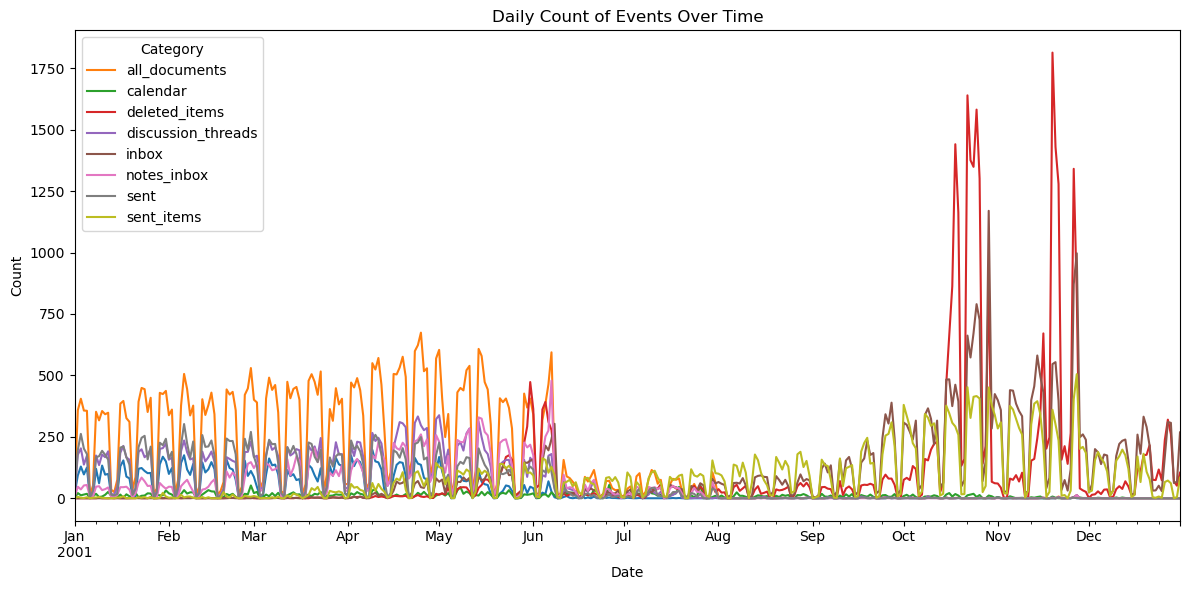

In [32]:
df_2001 = df_1999_2003[df_1999_2003.date_short.dt.year==2001]
daily_counts = df_2001.groupby(['date_short','sub_mailbox']).size().unstack(fill_value=0)


daily_counts

daily_counts.plot(
    kind='line',
    figsize=(12, 6),
    title='Daily Count of Events Over Time'
)

# Add labels for clarity
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

## Observation:

1. There seem some cleaning / deletion activities coinciding with US Gov audit scrutinity (around Oct 2001)
2. There is no overlapp emails from the three mailboxes sampled. We should scrape all sub folders and add to corpus
3. We don't have evidence yet that the high email deletion is due to hiding documents, 
    a. Could it be just abnormal email volume happening therefore more deletion happening?  OR
    b. Are those deleted have contents, Enron wants to hide from gov auditors?

### Pickling Organized dataframe for later use

In [34]:
merged_df.to_pickle('..\data\merged_df.pkl.gz', compression='gzip')

### 2. Cleaning email for text analysis

In [13]:
import re
import pandas as pd

def clean_email_text(text):
    # 1. Split the text at the forwarded header line.
    #    The header starts with '----- Forwarded by...'.
    # 2. Keep only the first part, which contains the original message.

    parts = text.split('----- Forwarded by')
    cleaned_text = parts[0]

    cleaned_text = cleaned_text.split('----- Original Message')
    cleaned_text = cleaned_text[0]

    # 3. Clean up the remaining newlines, tabs, and backslashes.
    cleaned_text = cleaned_text.replace('\n', ' ')
    cleaned_text = cleaned_text.replace('\t', ' ')
    cleaned_text = cleaned_text.replace('\\', '') # Use \\ to match a literal backslash.

    # 4. Remove any extra whitespace created during cleaning.
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


def extract_latest_reply_by_splitting(email_body):
    """
    Extracts the latest reply from an email thread using string splitting.

    Args:
        email_body (str): The full text of the email, including all replies.

    Returns:
        str: The latest reply, with whitespace and common separators removed.
    """
    # A list of common reply markers to look for, prioritized.
    common_separators = [
        # Outlook's standard reply separator.
        "-----Original Message-----",
        # A common separator for older emails or plain text replies.
        "---",
        # Generic reply header. This is less reliable.
        "From:",
        # The common "On [date]... wrote:" header.
        "wrote:",
        # Gmail and other web clients often use this for quoted text.
        ">",
    ]

    # Iterate through the list of separators and split the email body.
    for separator in common_separators:
        # Use a case-insensitive search to catch variations like "--Original Message--"
        if separator.lower() in email_body.lower():
            # Find the position of the first separator
            split_index = email_body.lower().find(separator.lower())
            # Return the text before the first separator, stripping excess whitespace.
            return email_body[:split_index].strip()
    
    # If no separators are found, assume the entire email is the latest reply.
    return email_body.strip()





### Unpickle saved dataframe

In [ ]:
merged_df_pick = pd.read_pickle('..\data\merged_df.pkl.gz', compression='gzip')

In [14]:
# test

test_rec=merged_df_pick.iloc[3002]

text=test_rec.email_body


# text=merged_df_pick.iloc[300,-1]

print(text)

print("-----cleaned text-----")

print(extract_latest_reply_by_splitting(clean_email_text(text)))

print("-----all record-----")

test_rec



Looks good.  I'm a little confused as to how many users can be on.  The 
system needs to be able to handle 50+ users at one time, each being able to 
post messages any time.  




Brian Hoskins@ENRON COMMUNICATIONS
09/28/2000 02:31 PM
To: Fangming Zhu/Corp/Enron@ENRON
cc: Allen Elliott/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT 
Subject: Re: requirement document   

Fangming,

Looks good.  That's exactly what we're looking for.  John, please comment if 
there are any additional features you'd like to add.

Brian


Brian T. Hoskins
Enron Broadband Services
713-853-0380 (office)
713-412-3667 (mobile)
713-646-5745 (fax)
Brian_Hoskins@enron.net





	Fangming Zhu@ENRON
	09/28/00 02:23 PM
		 
		 To: Brian Hoskins/Enron Communications@Enron Communications
		 cc: Allen Elliott/HOU/ECT@ECT
		 Subject: requirement document 

Hi, Brian:

Please review attached requirement document and reply this message with any 
comments. Once you approve it, I am going to build the application. 



Thanks,

Fangming

subject                                  Re: requirement document
date_short                                    2000-09-28 00:00:00
message_id          <16711226.1075857574831.JavaMail.evans@thyme>
from_addr                                   john.arnold@enron.com
person_box                                               Arnold-J
sub_mailbox                                         all_documents
sub_mailbox2                                                     
email_body      Looks good.  I'm a little confused as to how m...
Name: 3002, dtype: object